# Import Library

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Fetch Data

In [1]:
link = 'http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13'

code_df = pd.read_html(link, header=0)[0]
code_df

NameError: name 'pd' is not defined

# Cleansing the data

In [3]:
code_df.종목코드 = code_df.종목코드.map('{:06d}'.format)

code_df = code_df[['회사명', '종목코드']]
code_df = code_df.rename(columns={'회사명': 'name', '종목코드': 'code'})

# Show first 30 rows
code_df.head(n=30)

,name,code
0,BYC,001460
1,CJ CGV,079160
2,DB손해보험,005830
3,DGB금융지주,139130
4,DSR제강,069730
5,KB금융,105560
6,KC그린홀딩스,009440
7,KISCO홀딩스,001940
8,LS전선아시아,229640
9,MH에탄올,023150


# Get the name of specific  company, fetch that company's stock

In [4]:
def get_url(item_name, code_df):
    code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False)
    url = 'http://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=code)
    
    print("요청 URL = {}".format(url))
    return url

item_name = 'KB금융'
total_pages = 40

url = get_url(item_name, code_df)

df = pd.DataFrame()

for page in range(1, total_pages + 1):
    pg_url = '{url}&page={page}'.format(url=url, page=page)
    df = df.append(pd.read_html(pg_url, header=0)[0], ignore_index=True)
    
df = df.dropna()

df.head(n=10)

요청 URL = http://finance.naver.com/item/sise_day.nhn?code=105560


,날짜,종가,전일비,시가,고가,저가,거래량
0,2018.06.15,55000,1000,55900,55900,53800,1356696
1,2018.06.14,56000,900,57000,57200,55600,1174871
2,2018.06.12,56900,500,58000,58100,56700,1020141
3,2018.06.11,57400,1400,55800,57500,55800,1129584
4,2018.06.08,56000,100,56100,56700,55700,1038272
5,2018.06.07,56100,1100,56700,57100,55900,1366695
6,2018.06.05,55000,600,54700,55400,54400,1107743
7,2018.06.04,54400,2100,53000,54700,52800,1480544
8,2018.06.01,52300,500,52600,52800,52100,860865
9,2018.05.31,51800,600,53100,53100,51800,2297882


# Preprocessing the data

In [5]:
df = df.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff', 
                         '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'})

df[['close', 'diff', 'open', 'high', 'low', 'volume']] = df[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(int)

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['date'], ascending=True)
#df.set_index('date', inplace=False)

df.head(n=10)

,date,close,diff,open,high,low,volume
399,2016-10-27,42800,150,43150,43650,42100,635121
398,2016-10-28,41950,850,42050,43100,41850,1352349
397,2016-10-31,42300,350,42200,43200,42100,1245175
396,2016-11-01,41950,350,42250,42500,41300,1202041
395,2016-11-02,41000,950,41300,41650,40850,1525792
394,2016-11-03,41000,0,41000,41350,40650,1258303
393,2016-11-04,40400,600,40900,41000,40350,1068796
392,2016-11-07,40850,450,40800,41150,40450,891322
391,2016-11-08,40650,200,41200,41400,40650,938120
390,2016-11-09,40650,0,40750,41850,39850,2082848


# Plotly - plot all data

In [6]:
import plotly.plotly as py
import plotly.offline as offline
import plotly.graph_objs as go

from datetime import datetime

offline.init_notebook_mode(connected=True) 

trace = go.Candlestick(x=df.date,
                       open=df.open,
                       high=df.high,
                       low=df.low,
                       close=df.close)
data = [trace]
py.iplot(data, filename="candlestick", title="All Plot")

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~deltahotel93/0 or inside your plot.ly account where it is named 'candlestick'


# Plot moving average

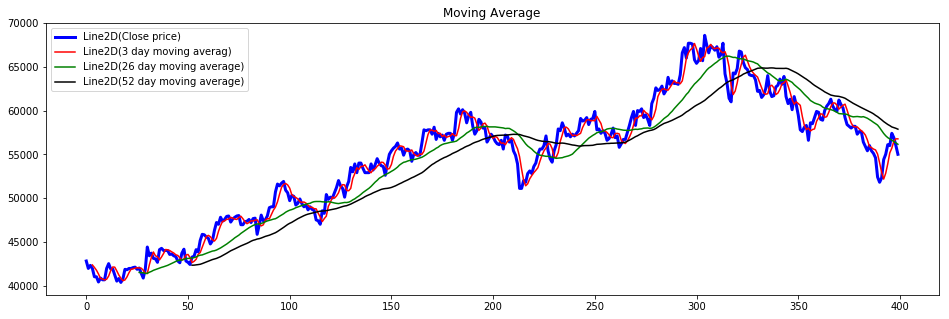

In [7]:
def moving_average(values, window):
    total_length = values.shape[0]
    
    mov_avg = []
    for i in range(total_length - window):
        mov_avg.append(np.mean(values[i:i+window]))
        
    return np.asarray(mov_avg)

vals = df.close.values
mov_avg1 = moving_average(vals, 3)
mov_avg2 = moving_average(vals, 26)
mov_avg3 = moving_average(vals, 52)

plt.figure(figsize=(16, 5))
plt.title("Moving Average")
l, = plt.plot(range(vals.shape[0]), vals, 'b', label='Close price', linewidth=3)
m1, = plt.plot(range(3, vals.shape[0]), mov_avg1, 'r', label='3 day moving averag')
m2, = plt.plot(range(26, vals.shape[0]), mov_avg2, 'g', label='26 day moving average')
m3, = plt.plot(range(52, vals.shape[0]), mov_avg3, 'k', label='52 day moving average')
plt.legend([l, m1, m2, m3])
plt.show()
plt.close()

# 전환선 / 기준선

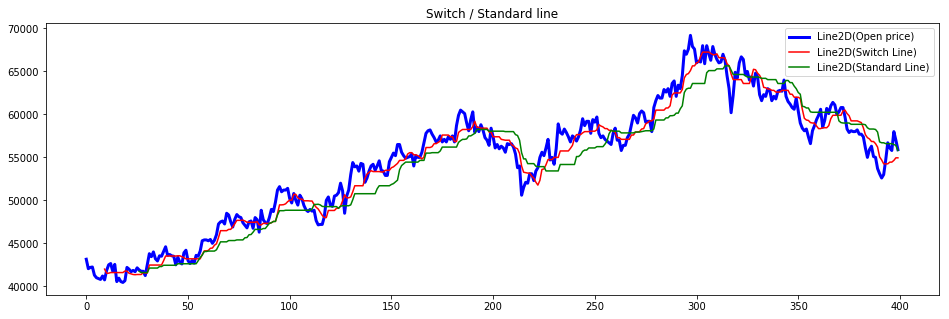

In [8]:
def switch_line(df):
    low = df['low'].values
    high = df['high'].values
    
    switch = []
    for i in range(9, df.shape[0]):
        switch.append((np.min(low[i-9:i]) + np.max(high[i-9:i])) / 2)
        
    return np.asarray(switch)

def standard_line(df):
    low = df['low'].values
    high = df['high'].values
    
    switch = []
    for i in range(26, df.shape[0]):
        switch.append((np.min(low[i-26:i]) + np.max(high[i-26:i])) / 2)
        
    return np.asarray(switch)

vals = df.open.values
swc_line = switch_line(df)
std_line = standard_line(df)

plt.figure(figsize=(16, 5))
plt.title("Switch / Standard line")
l, = plt.plot(range(vals.shape[0]), vals, 'b', label='Open price', linewidth=3)
swc, = plt.plot(range(9, vals.shape[0]), swc_line, 'r', label='Switch Line')
std, = plt.plot(range(26, vals.shape[0]), std_line, 'g', label='Standard Line')
plt.legend([l, swc, std])
plt.show()
plt.close()

# 선행스펜 1, 2 & 이격도

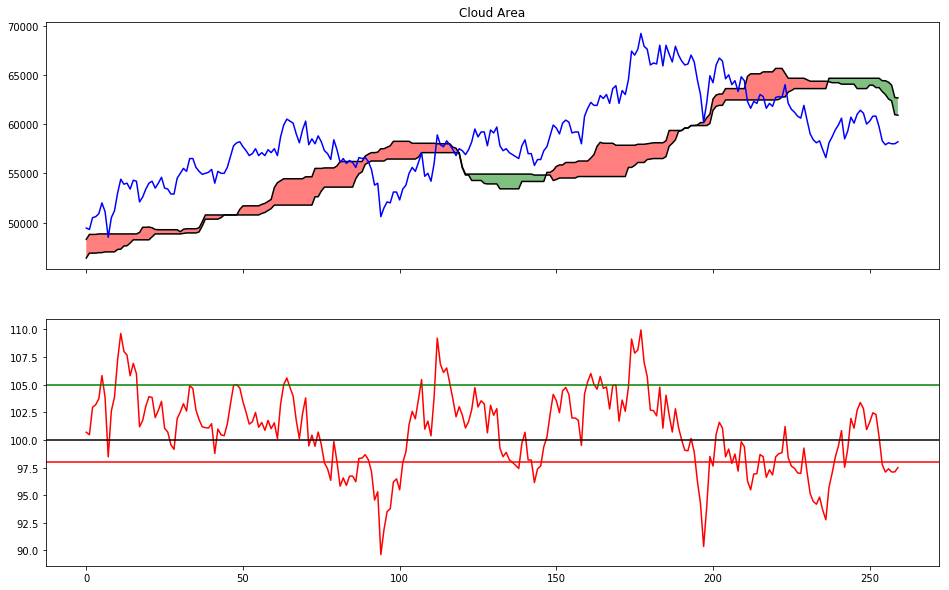

In [10]:
def pre_span1(df):
    low = df['low'].values
    high = df['high'].values
    
    pre_sp = []
    for i in range(26, df.shape[0]):
        pre_sp.append((np.max(high[i-26:i]) + np.min(low[i-26:i])) / 2)
        
    return np.asarray(pre_sp)

def pre_span2(df):
    low = df['low'].values
    high = df['high'].values
    
    pre_sp = []
    for i in range(52, df.shape[0]):
        pre_sp.append((np.max(high[i-52:i]) + np.min(low[i-52:i])) / 2)
        
    return np.asarray(pre_sp)

sp1 = pre_span1(df)
sp2 = pre_span2(df)

jars = np.zeros((6, vals.shape[0]))
jars[0] = vals
jars[1][9:] = swc_line
jars[2][26:] = std_line

jars[3][26+26:] = sp1[:-26]
jars[4][52+26:] = sp2[:-26]

avg = moving_average(vals, 20)
diparity = (vals[20:] / avg) * 100
jars[5][20:] = diparity

reranged = jars[:, 120:380]
x = np.arange(380 - 120)

fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 10))
ax.plot(x, reranged[3], x, reranged[4], color='k')
ax.fill_between(x, reranged[3], reranged[4], where=reranged[4] >= reranged[3], facecolor='green', interpolate=True, alpha=0.5)
ax.fill_between(x, reranged[3], reranged[4], where=reranged[4] < reranged[3], facecolor='red', interpolate=True, alpha=0.5)
ax.set_title('Cloud Area')
ax.plot(reranged[0], 'b')

ax2.plot(reranged[5], 'r')
ax2.axhline(y=100, color='k', linestyle='-')
ax2.axhline(y=98, color='r', linestyle='-')
ax2.axhline(y=105., color='g', linestyle='-')

plt.show()
plt.close()